**SVM**

**Student Name:** Prasanna Sundararajan Muthukumaran

**UTA ID:** 1001937587

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.datasets import load_iris

%matplotlib widget

In [2]:
def linear_kernel(x1, x2):
    return x1.T @ x2

def poly_kernel(x1, x2, c=1, degree=2):
    return (c + x1.dot(x2.T)) ** degree

class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000, degree=2):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self.degree = degree
        
        if self._kernel == 'linear':
            self._k = linear_kernel
        elif self._kernel == 'poly':
            self._k = poly_kernel

        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1
    
    def omptimization(self, alphas, targets, kernel, X):
        return np.sum(alphas) - 0.5 * np.sum((targets*targets) * kernel(X, X) * (alphas*alphas))
    
    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
                
        # TODO: the negative case
        elif eta < 0:
            L_opt = optimization(self._alphas, self._targets, self._k, self._data)
            H_opt = optimization(self._alphas, self._targets, self._k, self._data)
            if L_opt > (H_opt + self.tol):
                a2 = L
            elif L_opt < (H_opt - self.tol):
                a2 = H
            
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i, v in enumerate(np.random.permutation(range(self._data.shape[0]))):
                    if v == i2:
                        continue
                    if self.smo_step(v, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True
    
    def _decision_function(self, X):
        if (self._k == np.dot):
            return (self._alphas * self._targets).dot(self._k(self._data, X.T)) - self._b
        return (self._targets * self._alphas).dot(self._k(self._data, X)) - self._b

In [3]:
# Generating the dataset

n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.
samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


**Linear SVM**

weights=[ 0.47944893 -0.97858668]
b=0.3047387666604112
Model Accuracy =  100.0 %



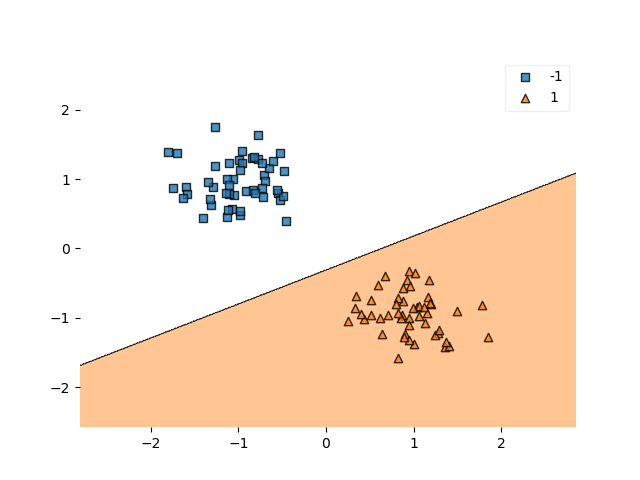

In [4]:
# Linear SVM Using User Defined Class

x_train, x_test, y_train, y_test = train_test_split(samples, targets, test_size=0.1, random_state=42, stratify=targets)
linear_model_user = svm(c = 5.0)
linear_model_user.fit(x_train, y_train)
print(f"weights={linear_model_user._weights}")
print(f"b={linear_model_user._b}")

print("Model Accuracy = ", (accuracy_score(y_test, linear_model_user.predict(x_test)) * 100), "%\n")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), linear_model_user)
fig.add_subplot(ax)
plt.show()

coef_=[[ 0.77854327 -0.81467287]]
intercept=[0.01743258]
Model Accuracy =  100.0 %



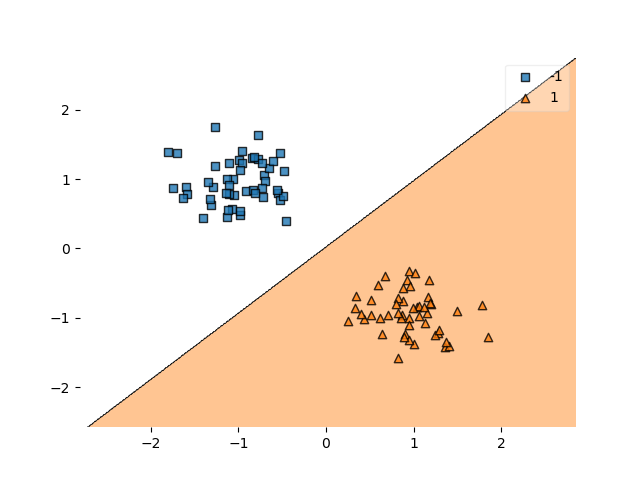

In [5]:
# Linear SVM Using Builtin 'LinearSVC' Function

x_train, x_test, y_train, y_test = train_test_split(samples, targets, test_size=0.1, random_state=42, stratify=targets)
linear_model_builtin = LinearSVC()
linear_model_builtin.fit(samples, targets.astype(np.int32))

print(f"coef_={linear_model_builtin.coef_}")
print(f"intercept={linear_model_builtin.intercept_}")

print("Model Accuracy = ", (accuracy_score(y_test, linear_model_builtin.predict(x_test)) * 100), "%\n")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), linear_model_builtin)
fig.add_subplot(ax)
plt.show()

**Non-Linear SVM**

weights=[-0.81904036 -1.40053867]
b=0.05457663546504328
Model Accuracy =  10.0 %



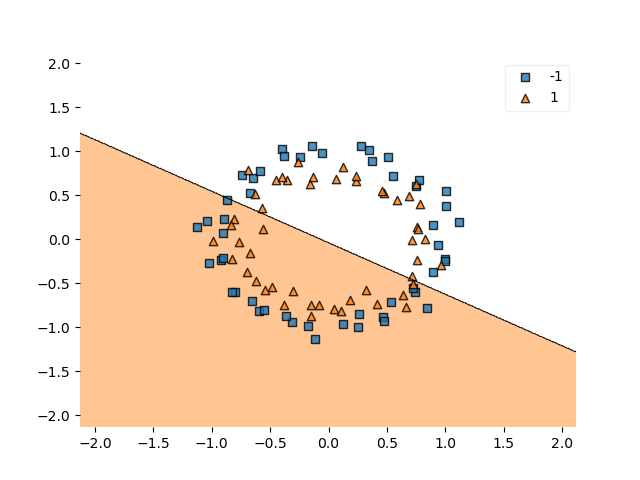

In [6]:
# Non-Linear SVM Using User Defined Class (Kernel = Linear)

x, y = datasets.make_circles(n_samples=100, shuffle=True, noise=0.08, random_state=42, factor=0.8)

# Changing the target values from (0,1) to (-1,1)
for i in range(len(y)):
    if y[i]==0:
        y[i]=-1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

nonlinear_model_user = svm(kernel='linear', c=1.0)
nonlinear_model_user.fit(x_train, y_train)

print(f"weights={nonlinear_model_user._weights}")
print(f"b={nonlinear_model_user._b}")

print("Model Accuracy = ", (accuracy_score(y_test, nonlinear_model_user.predict(x_test)) * 100), "%\n")

fig = plt.figure()
ax = plot_decision_regions(x, y.astype(np.int32), nonlinear_model_user)
fig.add_subplot(ax)
plt.show()

weights=[0.64136933 0.36077346]
b=-2.7939375676832316
Model Accuracy =  70.0 %



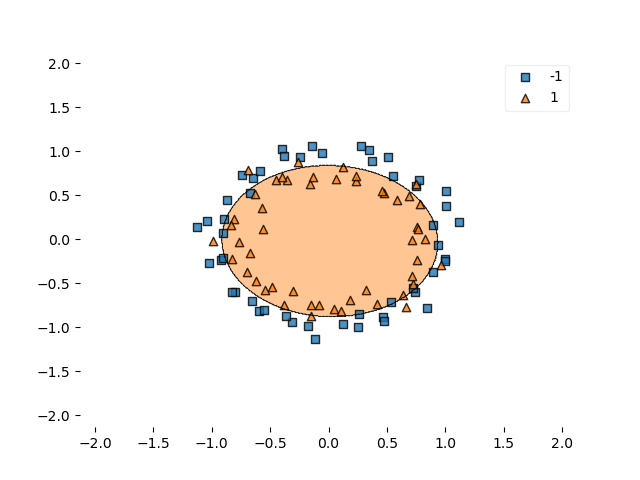

In [7]:
# Non-Linear SVM Using User Defined Class (Kernel = Poly)

x, y = datasets.make_circles(n_samples=100, shuffle=True, noise=0.08, random_state=42, factor=0.8)

# Changing the target values from (0,1) to (-1,1)
for i in range(len(y)):
    if y[i]==0:
        y[i]=-1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

nonlinear_model_user = svm(kernel='poly', c=1.0, maxiter=100)
nonlinear_model_user.fit(x_train, y_train)

print(f"weights={nonlinear_model_user._weights}")
print(f"b={nonlinear_model_user._b}")

print("Model Accuracy = ", (accuracy_score(y_test, nonlinear_model_user.predict(x_test)) * 100), "%\n")

fig = plt.figure()
ax = plot_decision_regions(x, y.astype(np.int32), nonlinear_model_user)
fig.add_subplot(ax)
plt.show()

coef_=[[-0.65356442 -0.87569627]]
intercept=[0.13707169]
Model Accuracy =  70.0 %



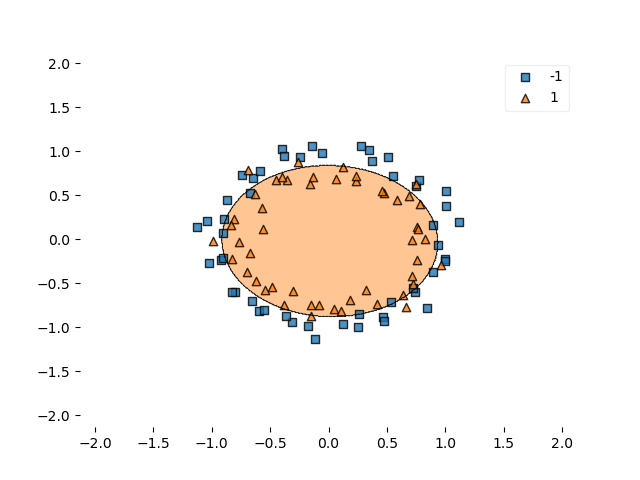

In [8]:
# Non-Linear SVM Using Builtin Function

x, y = datasets.make_circles(n_samples=100, shuffle=True, noise=0.08, random_state=42, factor=0.8)

# Changing the target values from (0,1) to (-1,1)
for i in range(len(y)):
    if y[i]==0:
        y[i]=-1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

nonlinear_model_builtin = SVC(kernel = 'linear', gamma='auto')
nonlinear_model_builtin.fit(x_train, y_train.astype(np.int32))

print(f"coef_={nonlinear_model_builtin.coef_}")
print(f"intercept={nonlinear_model_builtin.intercept_}")

print("Model Accuracy = ", (accuracy_score(y_test, nonlinear_model_user.predict(x_test)) * 100), "%\n")

fig = plt.figure()
ax = plot_decision_regions(x, y.astype(np.int32), nonlinear_model_user)
fig.add_subplot(ax)
plt.show()

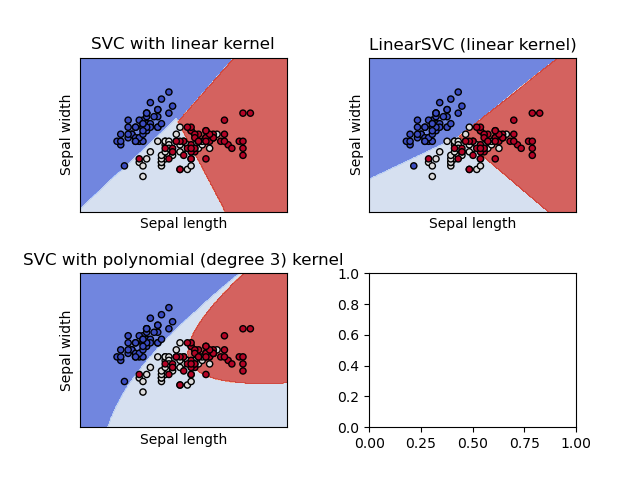

In [9]:
# Multi-Class SVM using Builtin 'SVC' Function

def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def iris_svm_builtin():
    # import some data to play with
    iris = datasets.load_iris()
    # Take the first two features. We could avoid this by using a two-dim dataset
    X = iris.data[:, :2]
    y = iris.target

    # we create an instance of SVM and fit out data. We do not scale our
    # data since we want to plot the support vectors
    C = 1.0  # SVM regularization parameter
    models = (
        SVC(kernel="linear", C=C),
        LinearSVC(C=C, max_iter=10000),
        SVC(kernel="poly", degree=3, gamma="auto", C=C),
    )
    models = (clf.fit(X, y) for clf in models)

    # title for the plots
    titles = (
        "SVC with linear kernel",
        "LinearSVC (linear kernel)",
        "SVC with polynomial (degree 3) kernel",
    )

    # Set-up 2x2 grid for plotting.
    fig, sub = plt.subplots(2, 2)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel("Sepal length")
        ax.set_ylabel("Sepal width")
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()

if __name__ == "__main__":
    iris_svm_builtin()

**References**

[1] https://github.com/ajdillhoff/CSE6363/tree/main/svm

[2] http://www.adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-training-algorithms/